In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
taxi_zones = gpd.read_file("data/taxi_zones.shp")
df = pd.read_csv("data/fhvhv_tripdata_2021-07.csv")

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# get number of trips for each location id
grouped_df = df.groupby(by=["PULocationID"])["hvfhs_license_num"].count()

# join on PULocationID
merged_df = pd.merge(taxi_zones, grouped_df, left_on="LocationID", right_on="PULocationID")
merged_df.rename(columns={"hvfhs_license_num": "num_trips"}, inplace=True)
merged_df

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,num_trips
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",293
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",62
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",34422
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",55634
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",3899
...,...,...,...,...,...,...,...,...
254,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",49933
255,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",64762
256,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",54282
257,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",52081


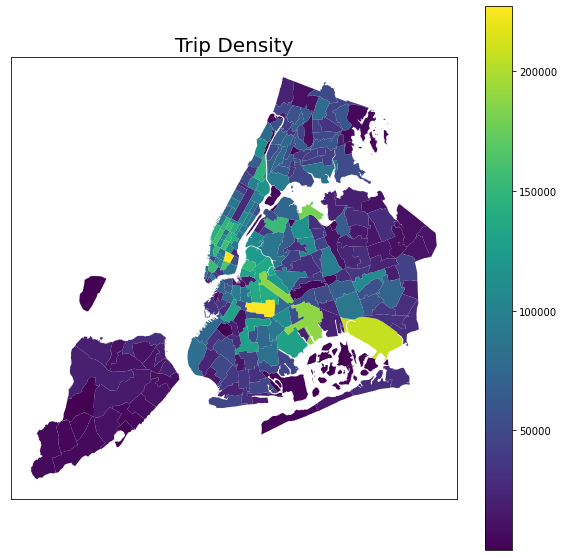

In [5]:
def plot_map(df, plot_title):
    f, ax = plt.subplots(1, figsize=(10, 10))
    df.plot("num_trips", ax=ax, aspect="auto", legend=True)

    # remove axis values
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    plt.title(plot_title, fontsize=20)

def save_as(file_name):
    plt.savefig(file_name, dpi=300)

plot_map(merged_df, "Trip Density")
save_as("trip_density.png")

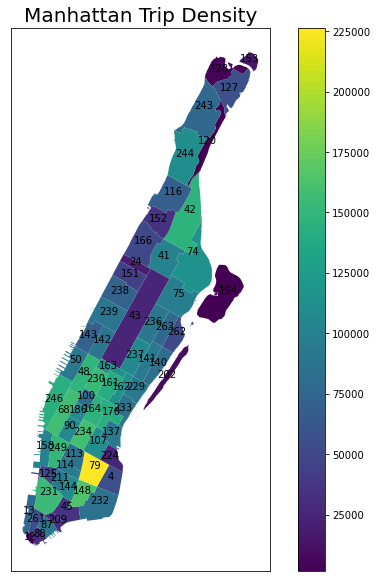

In [6]:
# Add coords for plot annotations
merged_df["coords"] = merged_df["geometry"].apply(lambda x: x.representative_point().coords[:])
merged_df["coords"] = [coords[0] for coords in merged_df["coords"]]

manhattan_df = merged_df[merged_df["borough"] == "Manhattan"].copy()
plot_map(manhattan_df, "Manhattan Trip Density")

def label(df, label):
    dfc = df.copy()
    for idx, row in dfc.iterrows():
        plt.annotate(text=row[label], xy=row["coords"],
                     horizontalalignment="center")
label(manhattan_df, "LocationID")
save_as("manhattan_map.png")